In [2]:
import torchattacks
from models.mnist_classifier.lenet import LeNet5_channel3
import torch
import torchvision
from torchvision.datasets import SVHN
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAMpp, GradCAM
import torchvision.models as models
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import os
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = LeNet5_channel3()
net_dir = 'autodl-tmp/save_model/svhn/lenet5/epoch=90_test_acc=0.886.pth'
net.load_state_dict(torch.load(net_dir))
net.eval()
net = net.to(device)

In [5]:
# 将数据集转换为PyTorch张量，并将像素值标准化为范围在0到1之间
data_root = './autodl-tmp/SVHN'
mean = [0.4377, 0.4438, 0.4728]
std = [0.1980, 0.2010, 0.1970]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
trainset = SVHN(root=data_root, split='train',
                 download=False,transform=transform)
testset = SVHN(root=data_root, split='test',
                download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=8)

In [6]:
(ims, labs) = next(iter(testloader))	# images：Tensor(64,1,28,28)、labels：Tensor(64,)
ims = ims.to(device)
labs = labs.to(device)

In [7]:
labs = labs.cpu().numpy()

In [8]:
# 计算预训练模型acc
preds = net(ims).cpu().detach().numpy()
class_preds = np.argmax(preds, axis=1)
print(class_preds)
print('test acc', np.sum(class_preds == labs) / 256)

[5 2 1 0 6 1 9 1 1 8 9 6 5 1 4 4 1 6 3 4 2 0 1 9 2 5 4 1 4 3 9 3 8 6 0 1 5
 1 1 2 2 1 6 3 2 8 1 2 0 6 9 1 5 1 9 6 4 5 1 2 2 8 2 4 1 0 6 9 3 2 3 5 1 1
 1 6 2 6 3 1 4 1 7 1 2 1 7 1 0 1 1 4 6 4 4 2 2 1 7 7 4 8 2 3 2 2 3 1 8 6 3
 7 6 1 0 7 2 7 4 2 8 8 1 7 1 9 1 4 2 9 6 1 3 8 8 2 0 1 0 3 1 2 4 6 7 2 1 3
 5 3 1 5 9 1 8 1 9 6 4 6 4 9 3 6 1 6 1 2 0 2 7 5 2 2 1 4 8 9 6 7 1 0 2 1 4
 8 3 2 1 6 2 6 1 7 7 3 6 1 1 3 7 2 1 5 6 2 1 0 4 7 1 0 2 3 7 3 1 1 1 2 0 1
 7 1 2 0 1 2 2 9 2 5 7 4 1 1 2 4 3 7 7 1 1 4 1 7 3 0 3 6 9 4 0 3 2 3]
test acc 0.8671875


In [9]:
loaders_scratch = {'train': trainloader, 'test': testloader}
X, Y = iter(loaders_scratch['test']).next()
X, Y = X.to(device), Y.to(device)
Y_logits = net(X)
Y_probs = F.softmax(Y_logits, dim=-1)
Y_preds = Y_probs.argmax(axis=-1)

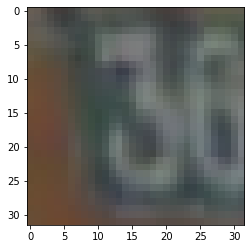

In [10]:
# 你下次打开肯定忘了：这里X是图像，Y是对应的标签，一共10000张。X[1:2][0]是(1,32,32)的一张图
orig_image = X[248:249][0].cpu().numpy().transpose(1, 2, 0)  # 交换通道
orig_image = orig_image * std + mean
plt.imshow(orig_image)
plt.show()

In [11]:
img_tensor = torch.unsqueeze(ims[248], dim=0).float()
img_variable = Variable(img_tensor, requires_grad=True)
output = net.forward(img_variable)
label_idx = int(torch.max(output.data, 1)[1][0])   #get an index(class number) of a largest element
print(label_idx)

3


In [ ]:
mnist_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
fashion_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
x_pred = fashion_labels[label_idx]
print(x_pred)

In [12]:
# PGD
y_true = label_idx   #change this if you change input image
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)

tensor([3])


In [13]:
# 将图像tensor归一化到0-1中
img_tensor = img_tensor.cpu()
min_val = torch.min(img_tensor)
max_val = torch.max(img_tensor)
img_tensor_normalized = (img_tensor - min_val) / (max_val - min_val)

In [14]:
eps = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
attack = torchattacks.PGD(net, eps=eps[4])
# perturbed_data = (torchattacks.BIM(model, epsilon, 0.2, steps=4))
perturbed_data = attack(img_tensor_normalized, target)

In [15]:
perturbed_data = perturbed_data.cpu()
noise = perturbed_data - img_tensor_normalized

In [16]:
# 去标准化
perturbed_data = perturbed_data * (max_val - min_val) + min_val

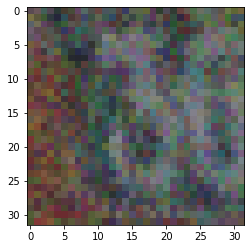

In [17]:
adv_image = perturbed_data[0].cpu().numpy().transpose(1, 2, 0)  # 交换通道
adv_image = adv_image * std + mean
plt.imshow(adv_image)
plt.show()

In [18]:
noise = noise * (max_val - min_val) + min_val

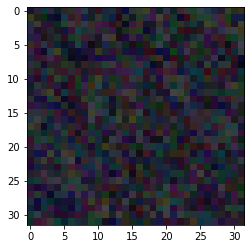

In [19]:
noise_map = noise[0].cpu().numpy().transpose(1, 2, 0)  # 交换通道
noise_map = noise_map * std + mean
plt.imshow(noise_map)
plt.show()

In [20]:
# 计算图像质量指标
import pytorch_ssim

def psnr(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    mse = F.mse_loss(img1.float(), img2.float())
    psnr = 10 * torch.log10(1/mse)
    return psnr

def mse(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    mse = F.mse_loss(img1.float(), img2.float())
    return mse

def ssim(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    ssim = pytorch_ssim.ssim(img1.float(), img2.float())
    return ssim

In [21]:
mse(perturbed_data, X[248:249]).item()

0.0993034839630127

In [22]:
ssim(X[248:249], perturbed_data).item()

0.5037599205970764

In [23]:
psnr(perturbed_data, X[248:249]).item()

10.030355453491211

In [24]:
perturbed_data.shape

torch.Size([1, 3, 32, 32])

In [ ]:
X[1:2].shape